# LABORATORIUM 9: Zastosowania DFT

## Zadanie 1: Analiza obrazów
Autor: Dariusz Marecik

Github link: https://github.com/FloudMe77/OCR

W tym zadaniu przeprowadzimy analizę obrazów przy użyciu Dyskretnej Transformaty Fouriera (DFT).
Główne cele:
1. Analiza obrazu w domenie częstotliwościowej
2. Wykrywanie wzorców przy użyciu korelacji w domenie częstotliwościowej


# Importowanie potrzebnych bibliotek

In [33]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage import maximum_filter



## 1. Analiza tekstu w domenie częstotliwościowej

Wczytamy obraz tekstu, dokonamy inwersji kolorów i przeprowadzimy analizę DFT.

### Funkcje do analizy obrazu w domenie częstotliwościowej

#### `read_image(name, to_gray_scale=True)`
Funkcja pomocnicza do wczytywania obrazów z możliwością konwersji do skali szarości.

In [ ]:
# Pomocnicza funkcja do wczytywania obrazów
def read_image(name, to_gray_scale=True):
    return Image.open(f"lab_images/{name}").convert("L") if to_gray_scale else Image.open(f"lab_images/{name}")

#### `compute_dft_components(img)`
Oblicza transformatę Fouriera dla obrazu. Dla obrazu kolorowego przetwarza każdy kanał osobno.

In [34]:
def compute_dft_components(img):
    if len(img.shape) == 3:
        # Kolorowy: każdy kanał osobno
        magnitude, phase = [], []
        for channel in range(3):
            dft = np.fft.fft2(img[:, :, channel])
            dft_shift = np.fft.fftshift(dft)
            magnitude.append(np.abs(dft_shift))
            phase.append(np.angle(dft_shift))
        return np.stack(magnitude, axis=2), np.stack(phase, axis=2)
    else:
        dft = np.fft.fft2(img)
        dft_shift = np.fft.fftshift(dft)
        return np.abs(dft_shift), np.angle(dft_shift)

#### `normalize_channels(data)`
Normalizuje wartości w kanałach do zakresu [0,1]. Dla obrazów kolorowych normalizuje każdy kanał niezależnie.

Normalizacja następuje według wzoru:
$pixel_{norm} = \frac{pixel - min}{max - min}$

In [35]:
def normalize_channels(data):
    norm = np.zeros_like(data)
    for i in range(data.shape[2]):
        channel = data[:, :, i]
        norm[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-9)
    return norm

#### `plot_dft_results(img, magnitude, phase, title_prefix)`
Tworzy kompleksową wizualizację wyników DFT, zawierającą:
1. Obraz oryginalny
2. Moduł DFT w skali logarytmicznej
3. Fazę DFT
4. Trójwymiarową wizualizację modułu DFT

Dla obrazów kolorowych wyświetla osobno składowe RGB.

In [36]:
def plot_dft_results(img, magnitude, phase, title_prefix):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Oryginalny obraz
    if len(img.shape) == 3:
        ax1.imshow(img)
        magnitude_log = np.log1p(magnitude)
        ax2.imshow(normalize_channels(magnitude_log))
        ax2.set_title(f'{title_prefix} - Moduł DFT (RGB, log scale)')
        ax3.imshow(normalize_channels(phase))
        ax3.set_title(f'{title_prefix} - Faza DFT (RGB)')
        magnitude_to_plot = magnitude_log[:, :, 1]  # kanał zielony
    else:
        ax1.imshow(img, cmap='gray')
        ax2.imshow(np.log1p(magnitude), cmap='gray')
        ax2.set_title(f'{title_prefix} - Moduł DFT (log scale)')
        ax3.imshow(phase, cmap='gray')
        ax3.set_title(f'{title_prefix} - Faza DFT')
        magnitude_to_plot = np.log1p(magnitude)

    ax1.set_title(f'{title_prefix} - Obraz oryginalny')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    # 3D wizualizacja
    y, x = np.mgrid[0:magnitude_to_plot.shape[0], 0:magnitude_to_plot.shape[1]]
    ax4 = fig.add_subplot(224, projection='3d')
    surf = ax4.plot_surface(x, y, magnitude_to_plot, cmap='viridis', linewidth=0, antialiased=True)
    ax4.set_title(f'{title_prefix} - Moduł DFT 3D')
    fig.colorbar(surf, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

#### `process_and_show_dft(img, title_prefix)`
Funkcja łącząca obliczanie i wizualizację DFT w jednym kroku. Wykorzystuje powyższe funkcje do pełnej analizy obrazu.

In [37]:
def process_and_show_dft(img, title_prefix):
    magnitude, phase = compute_dft_components(img)
    plot_dft_results(img, magnitude, phase, title_prefix)

#### `analyze_image_dft(image_path)`
Główna funkcja przeprowadzająca pełną analizę DFT obrazu. Wykonuje analizę zarówno dla:
- obrazu w skali szarości (oraz jego negatywu)
- obrazu kolorowego (wszystkie kanały RGB)

Pozwala na porównanie charakterystyk częstotliwościowych różnych reprezentacji tego samego obrazu.

In [38]:
def analyze_image_dft(image_path):
    # Wczytanie obrazów: w skali szarości i kolorowy
    image_gray = read_image(image_path, to_gray_scale=True)
    image_color = read_image(image_path, to_gray_scale=False)

    # Analiza obrazu w skali szarości
    process_and_show_dft(np.array(ImageOps.invert(image_gray)), "Skala szarości (negatyw)")
    process_and_show_dft(np.array(image_gray), "Skala szarości")

    # Analiza obrazu kolorowego
    process_and_show_dft(np.array(image_color), "Obraz kolorowy")

## Przedstawienie wartości fazy i modułu współczynników Fouriera 

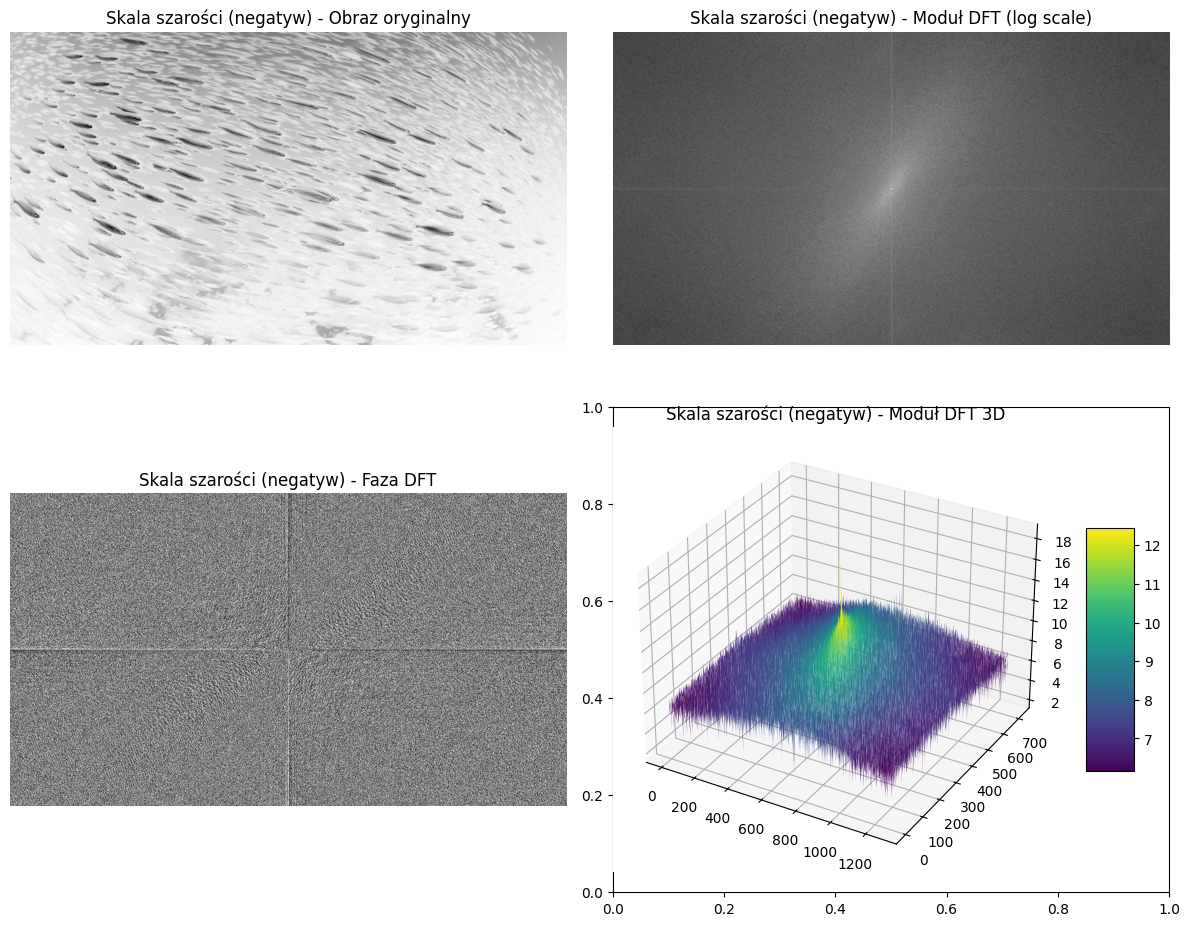

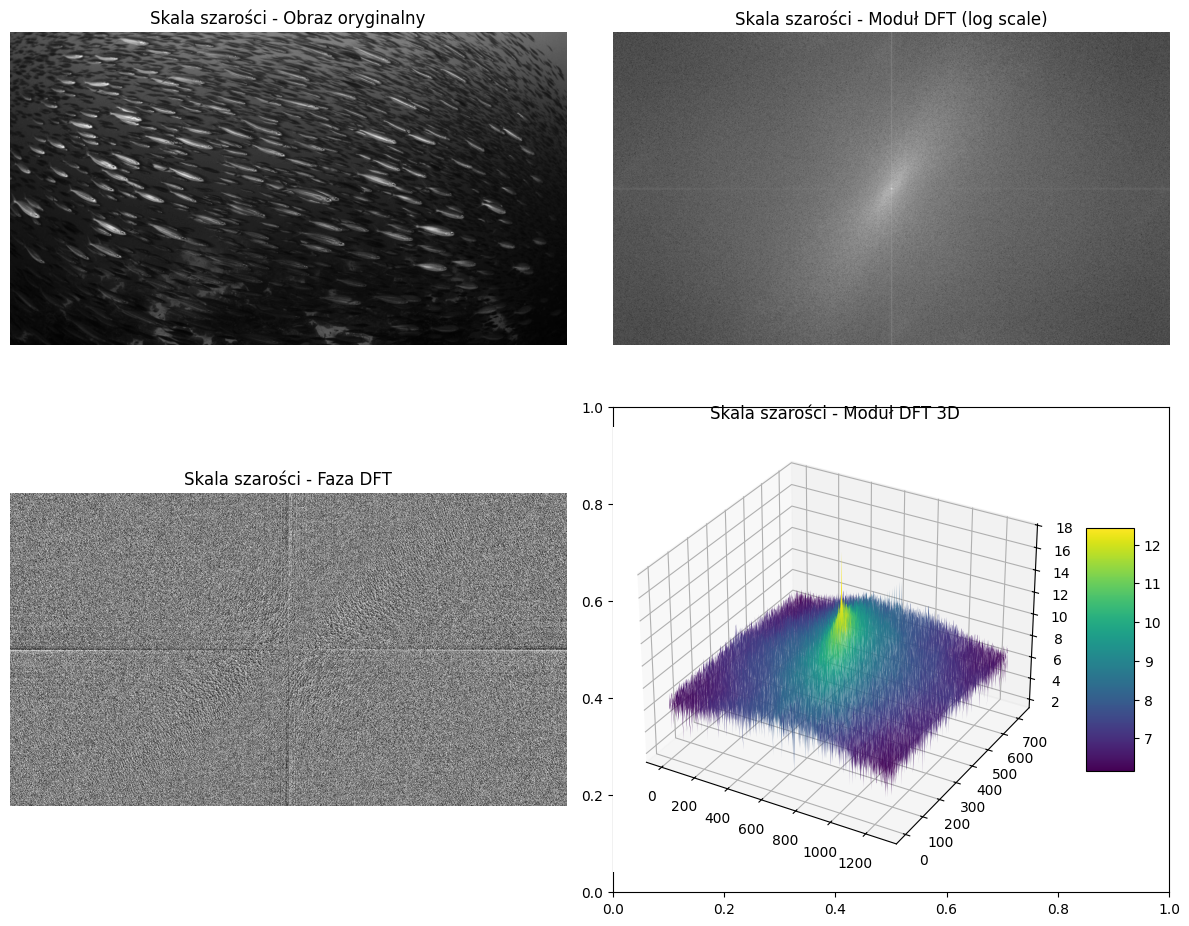

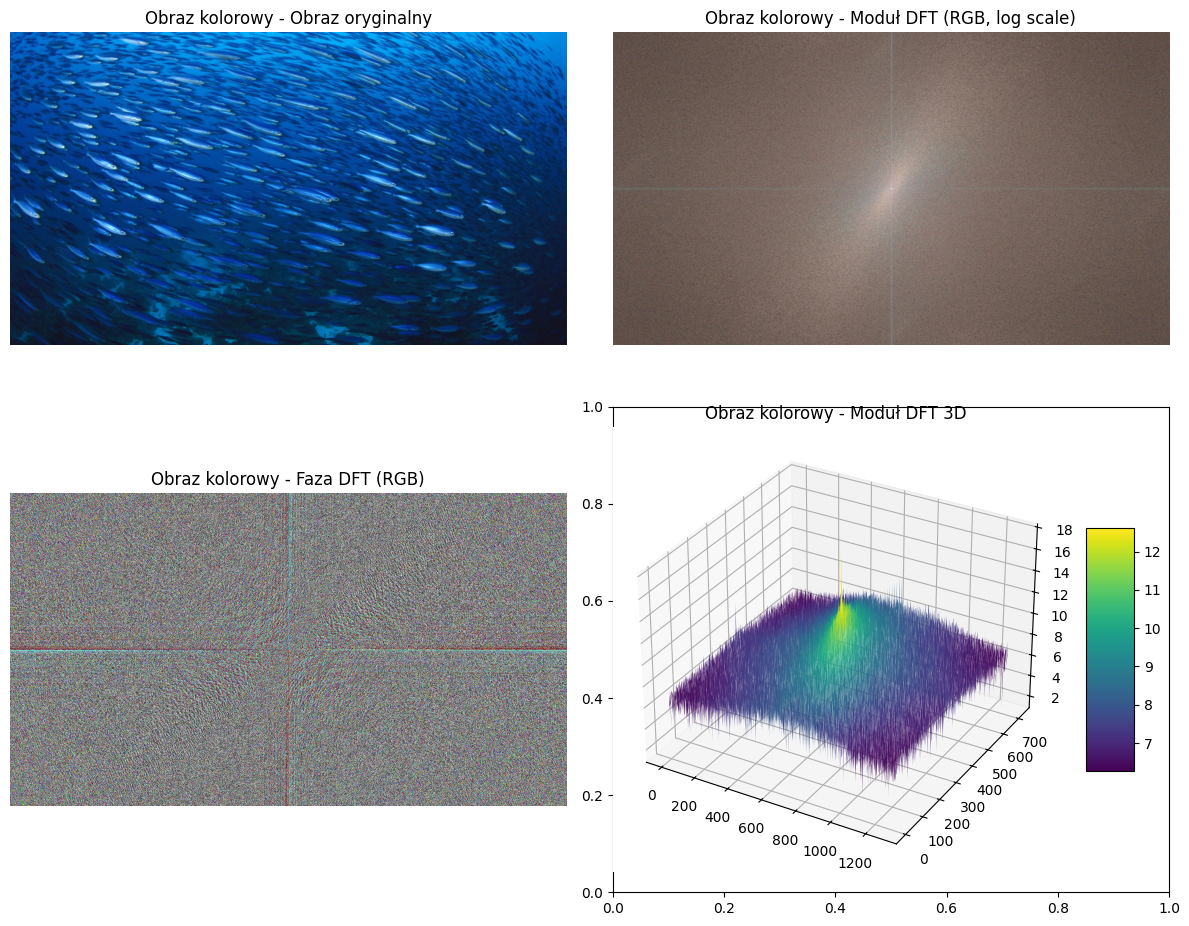

In [39]:
analyze_image_dft("school.jpg")

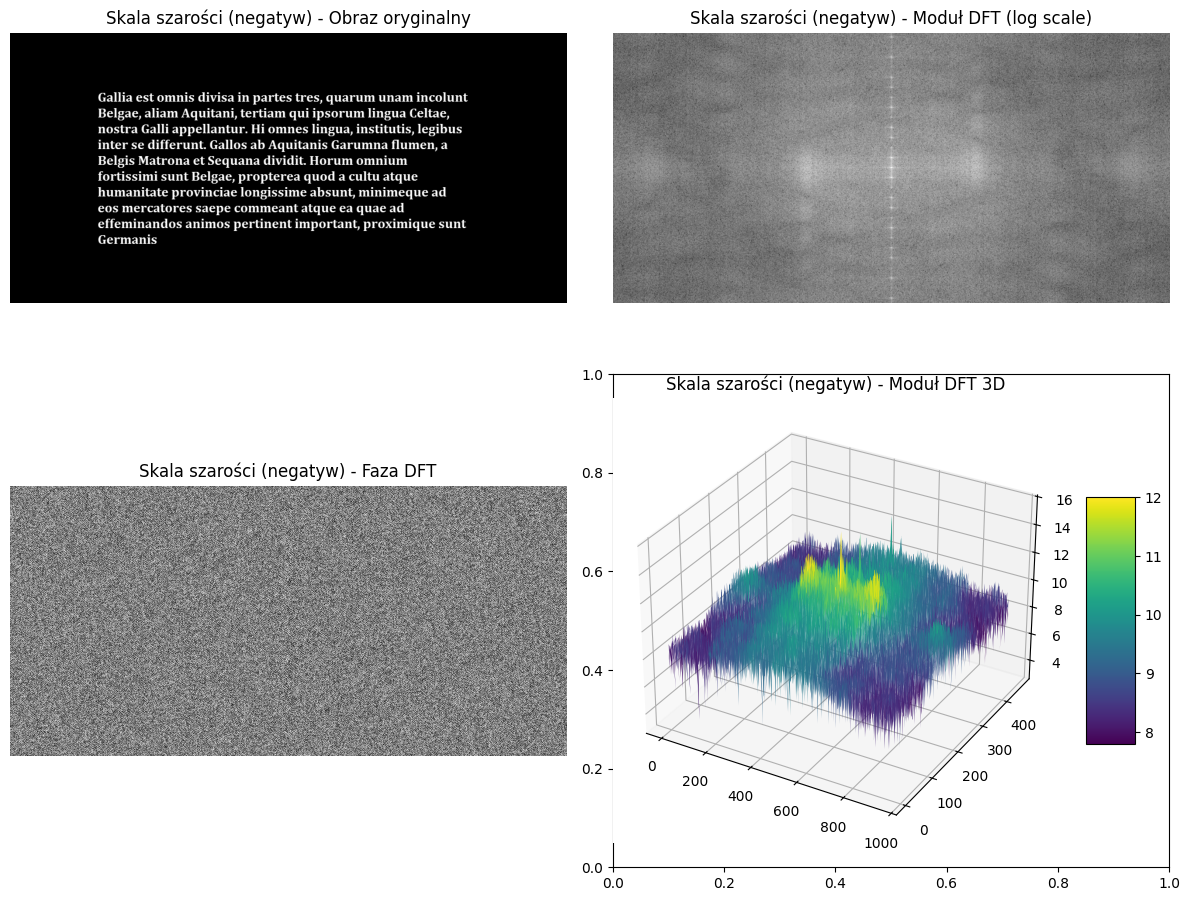

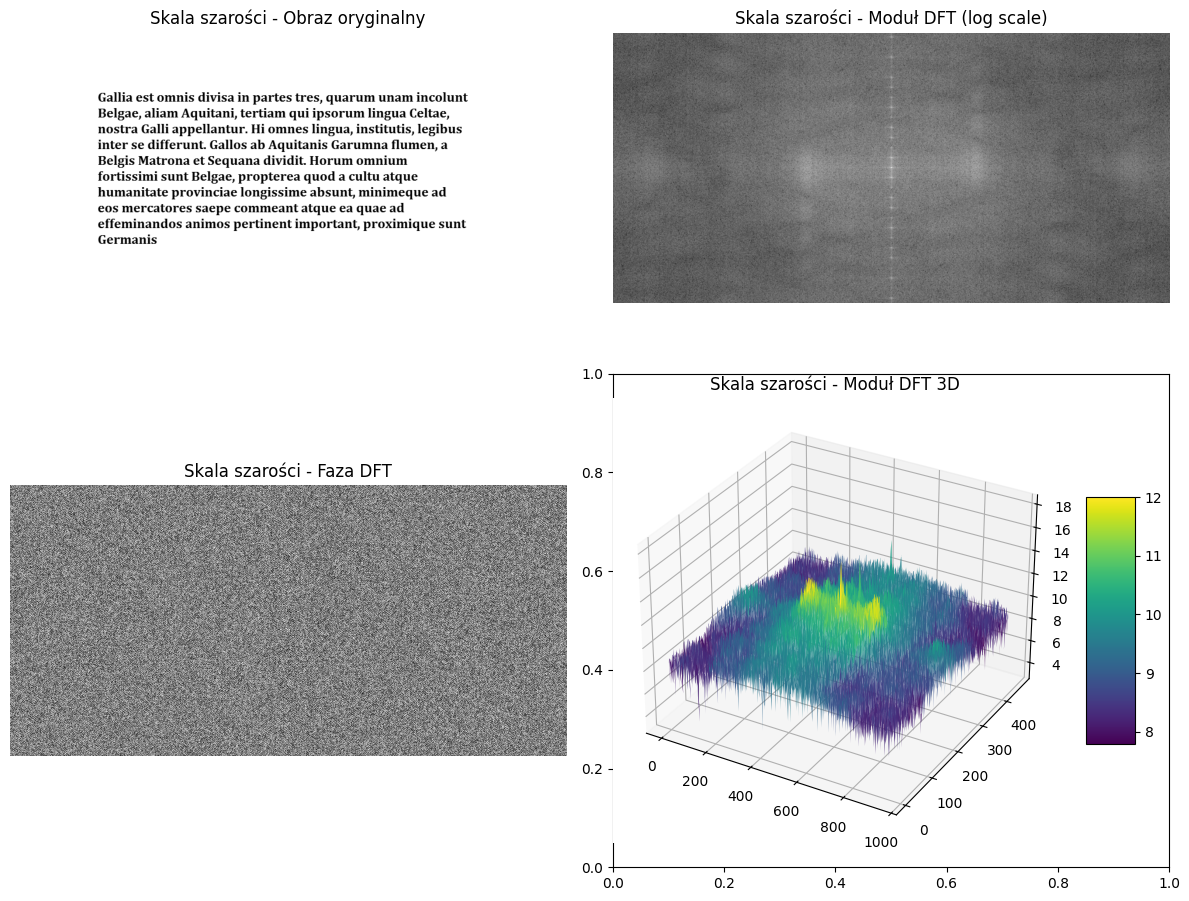

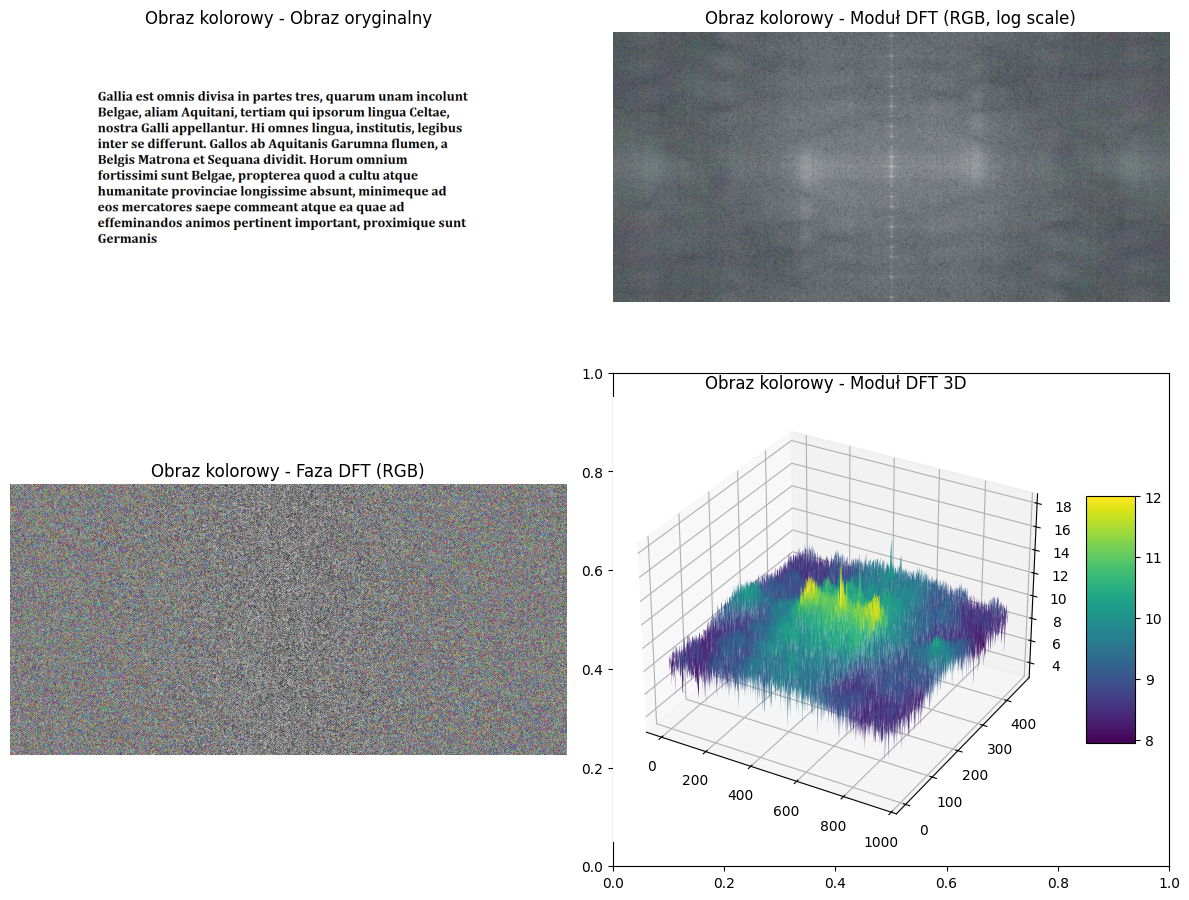

In [40]:
analyze_image_dft("galia.png")

## 2. Wykrywanie wzorców za pomocą korelacji w domenie częstotliwościowej

Zaimplementujemy i przetestujemy wykrywanie wzorców na dwóch przykładach:
1. Wykrywanie litery 'e' w tekście
2. Wykrywanie ryby w obrazie ławicy

#### `match_template_dft(image, template)`
Korelacja wzajemna w domenie Fouriera jest obliczana jako:

$C(u,v) = F^{-1}\{F(u,v) \cdot H^*(u,v)\}$

gdzie:
- $F(u,v)$ to transformata Fouriera obrazu
- $H^*(u,v)$ to sprzężenie zespolone transformaty Fouriera szablonu
- $F^{-1}$ oznacza odwrotną transformatę Fouriera

W implementacji wykorzystujemy fakt, że rotacja szablonu o 180° w dziedzinie przestrzennej jest równoważna sprzężeniu zespolonemu w dziedzinie częstotliwości.

In [ ]:
def match_template_dft(image, template):
    # Normalizacja template
    template = template / np.sum(template)
    template_rotated = np.rot90(template, 2)
    
    # Padding szablonu do rozmiaru obrazu
    padded_template = np.zeros_like(image, dtype=np.float32)
    padded_template[:template.shape[0], :template.shape[1]] = template_rotated
    
    # Korelacja w domenie częstotliwości
    F_image = np.fft.fft2(image)
    F_template = np.fft.fft2(padded_template)
    correlation = np.real(np.fft.ifft2(F_image * F_template))
    
    return correlation

#### `find_matches(image_path, template_path, threshold=0.9, min_distance=10, invert=True)`

Funkcja służy do detekcji wzorców w obrazie przy użyciu korelacji wzajemnej w domenie częstotliwościowej.

**Zasada działania:**
1. Wczytanie obrazu i wzorca, opcjonalna inwersja kolorów
2. Obliczenie korelacji wzajemnej w domenie częstotliwościowej
3. Normalizacja mapy korelacji do zakresu [0,1]
4. Detekcja lokalnych maksimów spełniających warunki:
   - Wartość korelacji ≥ threshold
   - Odległość od innych maksimów ≥ min_distance

Korelacja wskazuje na silne dopasowanie, gdy jej wartość jest bliska 1.

**Parametry:**
- `threshold`: Próg akceptacji dopasowania (0.95 dla tekstu, 0.6 dla ryb)
- `min_distance`: Minimalna odległość między znalezionymi wzorcami
- `invert`: Flaga inwersji kolorów (True dla czarnego tekstu na białym tle)

**Wizualizacja:**
- Znalezione dopasowania zaznaczane są czerwonymi okręgami
- Mapa korelacji przedstawiona w formie wykresu 3D

Test 1: Wykrywanie litery 'e' w tekście


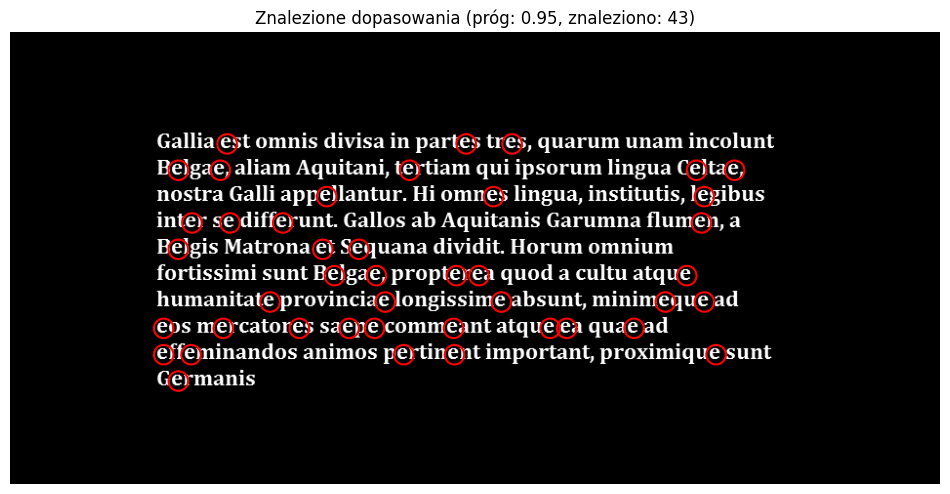

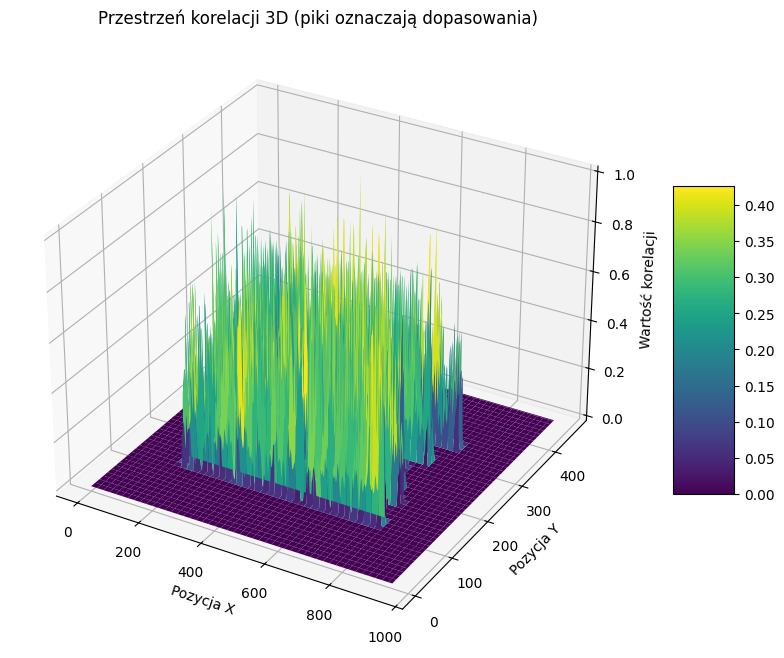

Liczba znalezionych wystąpień: 43

Test 2: Wykrywanie ryby w ławicy


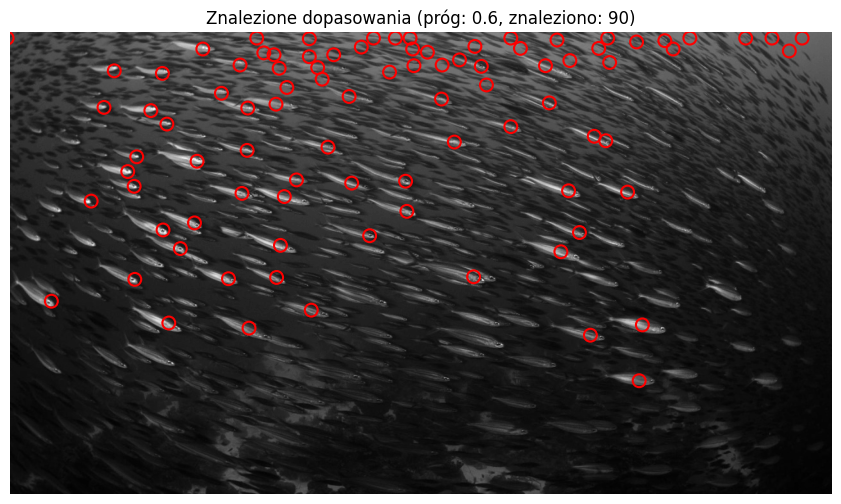

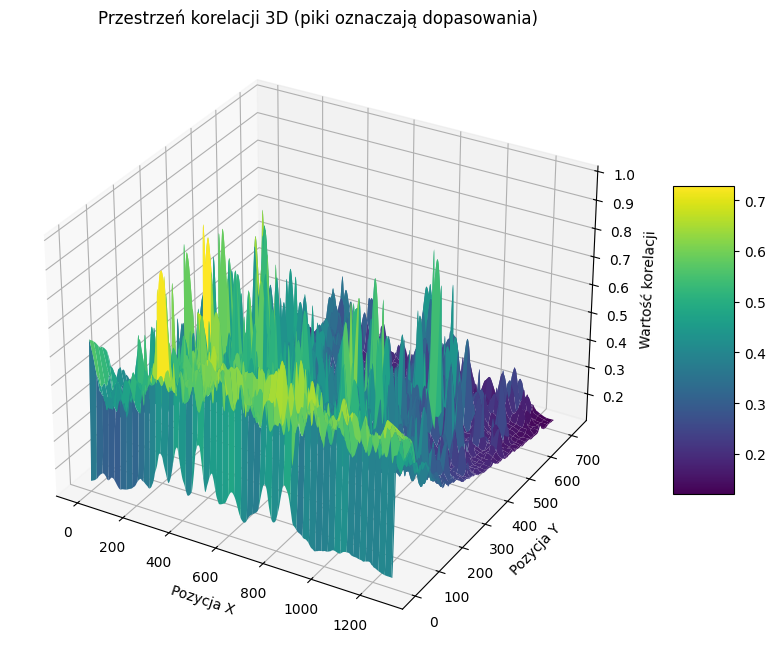

Liczba znalezionych wystąpień: 90


In [44]:
def find_matches(image_path, template_path, threshold=0.9, min_distance=10, invert = True):
    # Wczytanie obrazów
    image = read_image(image_path)
    template = read_image(template_path)
    
    # Konwersja na tablice i inwersja
    if invert:
        image = ImageOps.invert(image)
        template = ImageOps.invert(template)
    img_array = np.array(image)
    template_array = np.array(template)
    
    # Obliczenie korelacji i normalizacja
    correlation = match_template_dft(img_array, template_array)
    correlation_norm = correlation / np.max(correlation)
    
    # Znalezienie lokalnych maksimów
    local_max = maximum_filter(correlation_norm, size=min_distance) == correlation_norm
    matches = np.argwhere((correlation_norm >= threshold) & local_max)
    
    # Wizualizacja wyników
    plt.figure(figsize=(12, 6))
    plt.imshow(img_array, cmap='gray')
    
    for (y, x) in matches:
        circle = Circle((x-5, y-5), radius=10, edgecolor='red', facecolor='none', linewidth=1.5)
        plt.gca().add_patch(circle)
    
    plt.title(f'Znalezione dopasowania (próg: {threshold}, znaleziono: {len(matches)})')
    plt.axis('off')
    plt.show()
    
    # Dodatkowa wizualizacja 3D przestrzeni korelacji
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Przygotowanie siatki dla wykresu 3D
    y, x = np.mgrid[0:correlation_norm.shape[0], 0:correlation_norm.shape[1]]
    
    # Wyświetlenie powierzchni 3D
    surf = ax.plot_surface(x, y, correlation_norm,
                          cmap='viridis',
                          linewidth=0,
                          antialiased=True)
    
    ax.set_title('Przestrzeń korelacji 3D (piki oznaczają dopasowania)')
    ax.set_xlabel('Pozycja X')
    ax.set_ylabel('Pozycja Y')
    ax.set_zlabel('Wartość korelacji')
    
    # Dodanie paska kolorów
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.show()
    
    return len(matches)

# Test na obu zbiorach danych
print("Test 1: Wykrywanie litery 'e' w tekście")
matches_count = find_matches("galia.png", "galia_e.png", threshold=0.95, min_distance=15)
print(f"Liczba znalezionych wystąpień: {matches_count}\n")

print("Test 2: Wykrywanie ryby w ławicy")
matches_count = find_matches("school.jpg", "fish1.png", threshold=0.6, min_distance=20, invert=False)
print(f"Liczba znalezionych wystąpień: {matches_count}")

## Wnioski z analizy

### 1. Analiza obrazów w domenie częstotliwościowej
- Moduł DFT pokazuje dominujące częstotliwości w obrazie
- W przypadku tekstu widoczne są regularne wzorce odpowiadające odstępom między literami
- Dla obrazu ławicy ryb widoczne są głównie niskie częstotliwości odpowiadające ogólnej strukturze sceny

### 2. Wykrywanie wzorców
1. **Tekst (litera 'e')**:
   - Znaleziono 43 wystąpienia litery 'e'
   - Wysoki próg (0.95) zapewnia dokładne dopasowania
   - Bardzo dobra skuteczność dla tekstu dzięki jednolitemu formatowaniu

2. **Ławica ryb**:
   - Wykryto 90 ryb w obrazie
   - Niższy próg (0.6) uwzględnia naturalne różnice w wyglądzie ryb
   - Skuteczne mimo różnych orientacji i częściowego przesłonięcia ryb

### 3. Efektywność metody
- DFT pozwala na szybkie obliczenie korelacji dla dużych obrazów
- Metoda radzi sobie z różnymi typami wzorców (tekst i obiekty naturalne)
- Wymaga dostrojenia parametrów (threshold, min_distance) do konkretnego przypadku